#In this version i'm concatenating the IHC and H&E images in a single one 224x224 size. in this version i switch to a 80 - 20 split instead the initial 72 - 8 - 20 one. batch size = 256




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import csv
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.optim import Adam

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms

In [ ]:

def write_csv_from_folder(folder_path, csv_file_path):
    # List all files in the given folder
    files = os.listdir(folder_path)

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['id', 'her2_score'])  # Writing the header
        existing_rows = []
        for filename in files:
            # Split the filename to extract the ID and the HER2 score
            # Example filename: "12345_train_2.jpg"
            parts = filename.split('_')
            if len(parts) < 3:
                print("Skipped image")
                continue  # Skip files that don't match the expected pattern
            image_id = parts[0]
            her2_score = parts[2].split('.')[0][0]  # Remove the file extension and get the score
            row = [image_id, her2_score]
            if row not in existing_rows:
                writer.writerow(row)
                existing_rows.append(row)

# Define the paths to the train and test folders
train_folder_path = '/content/drive/MyDrive/Final Project/BCI_dataset/IHC/train'
test_folder_path = '/content/drive/MyDrive/Final Project/BCI_dataset/IHC/test'

# Define the paths for the output CSV files
train_csv_path = 'train_data.csv'
test_csv_path = 'test_data.csv'

# Process the train and test folders and write to CSV files
write_csv_from_folder(train_folder_path, train_csv_path)
write_csv_from_folder(test_folder_path, test_csv_path)

row_count_train = 0
row_count_test = 0

with open(train_csv_path) as f:
    row_count_train = sum(1 for line in f)

with open(test_csv_path) as f:
    row_count_test = sum(1 for line in f)



print("CSV files have been created.")
print(f"Train dataset lenght = {row_count_train}")
print(f"Test dataset lenght = {row_count_test}")

CSV files have been created.
Train dataset lenght = 3897
Test dataset lenght = 978


In [ ]:
class HER2Dataset(Dataset):
    def __init__(self, root_dir, labels_file, transform=None, train=True):
        """
        Args:
            root_dir (string): Directory with all the image pairs.
            labels_file (string): Path to the CSV file with labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.labels = pd.read_csv(labels_file)
        self.transform = transform
        if train:
          self.image_pairs = [(os.path.join(root_dir, 'IHC/train', f), os.path.join(root_dir, 'HE/train', f))
                            for f in os.listdir(os.path.join(root_dir, 'IHC/train'))]
        else:
          self.image_pairs = [(os.path.join(root_dir, 'IHC/test', f), os.path.join(root_dir, 'HE/test', f))
                            for f in os.listdir(os.path.join(root_dir, 'IHC/test'))]

        for pair in self.image_pairs:
          if "(1)" in pair[0]:
            self.image_pairs.remove(pair)
    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        ihc_img_path, he_img_path = self.image_pairs[idx]
        ihc_image = Image.open(ihc_img_path).convert("RGB")
        he_image = Image.open(he_img_path).convert("RGB")

        concatenated_image = Image.new('RGB', (ihc_image.width + he_image.width, ihc_image.height))
        concatenated_image.paste(ihc_image, (0, 0))
        concatenated_image.paste(he_image, (ihc_image.width, 0))

        if self.transform:
            concatenated_image = self.transform(concatenated_image)

        label = self.labels.iloc[idx]['her2_score']  # Assuming 'her2_score' column in CSV

        return concatenated_image, label  # Return both images and the label

# Example of setting up the dataset with transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset_train = HER2Dataset(root_dir='/content/drive/MyDrive/Final Project/BCI_dataset/', labels_file='train_data.csv', transform=transform)
dataset_test = HER2Dataset(root_dir='/content/drive/MyDrive/Final Project/BCI_dataset/', labels_file='test_data.csv', transform=transform,train=False)

In [ ]:
# Load the CSV file into a DataFrame
df = pd.read_csv('train_data.csv')

# Count the instances in each class for the 'her2_score' column
class_counts = df['her2_score'].value_counts()

# Display the counts
print(class_counts)

her2_score
2    1697
3    1078
1     919
0     202
Name: count, dtype: int64


In [ ]:
# Load the CSV file into a DataFrame
df = pd.read_csv('test_data.csv')

# Count the instances in each class for the 'her2_score' column
class_counts = df['her2_score'].value_counts()

# Display the counts
print(class_counts)

her2_score
2    446
3    258
1    235
0     38
Name: count, dtype: int64


Class Distribution Plots

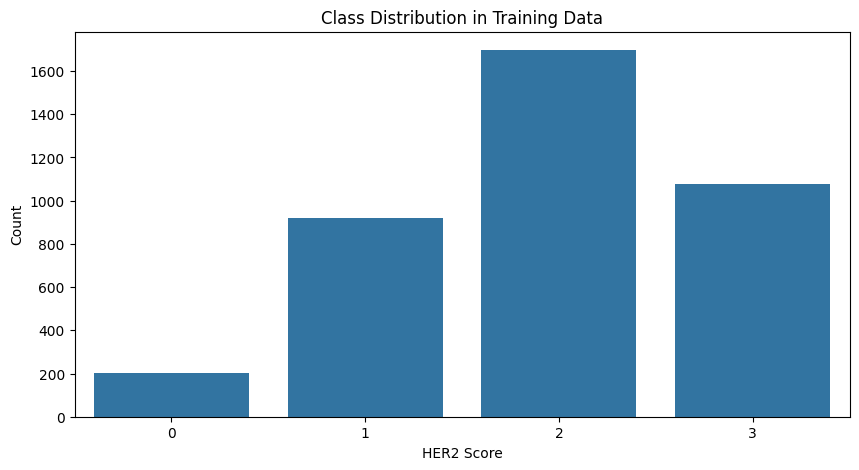

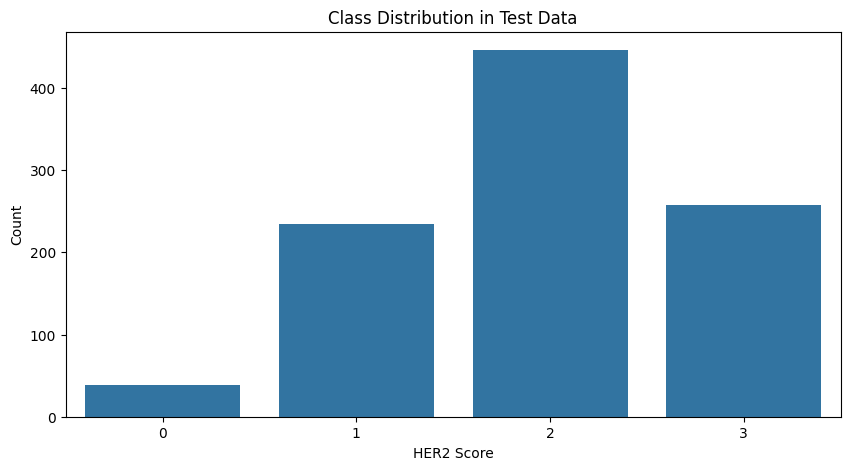

In [ ]:
df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')

plt.figure(figsize=(10, 5))
sns.countplot(x='her2_score', data=df_train)
plt.title('Class Distribution in Training Data')
plt.xlabel('HER2 Score')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='her2_score', data=df_test)
plt.title('Class Distribution in Test Data')
plt.xlabel('HER2 Score')
plt.ylabel('Count')
plt.show()

In [ ]:
# Define the model
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetClassifier(num_classes=4).to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
losses_training = []
losses_validation = []
accuracies_training = []
accuracies_validation = []
num_epochs = 75

In [ ]:

# Define the training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs):
    scaler = GradScaler()
    best_val_loss = float('inf')
    patience = 5
    trigger_times = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_correct = 0

        total_data_points = 0
        misclassified_details = {}


        for ids, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            # print(f"id = {ids}")
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            total_data_points += inputs.size(0)
            total_correct += (outputs.argmax(dim=1) == targets).sum().item()

            predictions = outputs.argmax(dim=1)
            for target, prediction in zip(targets, predictions):
                if target != prediction:
                    target_class = target.item()
                    pred_class = prediction.item()
                    if target_class not in misclassified_details:
                        misclassified_details[target_class] = []
                    misclassified_details[target_class].append(pred_class)





        # Print misclassified details for each class
        for cls, predictions in misclassified_details.items():
            print(f'Class {cls} misclassified {len(predictions)} times. Predicted as: {predictions}')

        accuracy = total_correct / total_data_points
        epoch_loss = running_loss / total_data_points
        losses_training.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')
        accuracies_training.append(accuracy)
        validate_model(model, val_loader, criterion, device=device)


        # # Check early stopping
        # if epoch_loss < best_val_loss:
        #     best_val_loss = epoch_loss
        #     trigger_times = 0
        # else:
        #     trigger_times += 1
        #     if trigger_times >= patience:
        #         print('Early stopping!')
        #         break


def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_correct = 0
    total_data_points = 0
    misclassified_details = {}

    y_true = []
    y_pred = []
    with torch.no_grad():
        for ids, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            total_correct += (outputs.argmax(dim=1) == targets).sum().item()
            total_data_points += inputs.size(0)

            # Calculate misclassifications
            predictions = outputs.argmax(dim=1)
            for target, prediction in zip(targets, predictions):
                y_true.append(target.cpu().numpy())
                y_pred.append(prediction.cpu().numpy())
                if target != prediction:
                    target_class = target.item()
                    pred_class = prediction.item()
                    if target_class not in misclassified_details:
                        misclassified_details[target_class] = []
                    misclassified_details[target_class].append(pred_class)

    epoch_loss = running_loss / total_data_points
    accuracy = total_correct / total_data_points
    losses_validation.append(epoch_loss)
    accuracies_validation.append(accuracy)

    print(f'Validation Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Print misclassified details for each class
    for cls, predictions in misclassified_details.items():
        print(f'Class {cls} misclassified {len(predictions)} times. Predicted as: {predictions}')

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



train_loader = DataLoader(dataset_train, batch_size=256)
val_loader = DataLoader(dataset_test, batch_size=256)

# Initialize the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)




In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/Final Project/model.pth'))
# model.eval()

In [ ]:
# Start training
train_model(model, train_loader, val_loader, criterion, optimizer, device=device, num_epochs=num_epochs)

KeyboardInterrupt: 

Losses plots

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Final Project/final_project_spli80_20_batchsize_256.pth')

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses_training, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(range(num_epochs), losses_validation, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Accuracies Plots


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), accuracies_training, marker='o', linestyle='-', color='b', label='Training Accuracy')
plt.plot(range(num_epochs), accuracies_validation, marker='o', linestyle='-', color='r', label='Validation Accuracy')
plt.title('Accuracy Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# val_loader = DataLoader(dataset, batch_size=1, sampler=val_sampler)

# def get_sample_predictions(num_samples, val_dataloader):
#   sample_images = []
#   sample_true_labels = []
#   sample_pred_labels = []
#   counter = 0
#   for ids, (inputs, targets) in enumerate(val_dataloader):
#     inputs, targets = inputs.to(device), targets.to(device)
#     outputs = model(inputs)
#     image = Image.open(transforms.ToPILImage()(inputs[0])).convert('RGB')  # Load image and convert to RGB
#     sample_images.append(image.cpu().squeeze(0))
#     sample_true_labels.append(targets)
#     sample_pred_labels.append(outputs)
#     if counter == num_samples:
#       break
#     else:
#       counter += 1


#   return sample_images, sample_true_labels, sample_pred_labels


# def load_image(image_path):
#     image = Image.open(image_path).convert('RGB')  # Load image and convert to RGB
#     image = transform(image)  # Apply transformations
#     return image

# def get_sample_predictions(root_dir, model, n_iter, device):
#     model.eval()
#     sample_images = []
#     sample_true_labels = []  # This should be provided along with the image paths
#     sample_pred_labels = []
#     counter = 0
#     with torch.no_grad():
#         for image_path in os.listdir(root_dir):
#             image = load_image(root_dir + image_path)
#             input = image.to(device).unsqueeze(0)  # Add batch dimension and move to device
#             output = model(input)
#             pred_label = output.argmax(dim=1).item()

#             sample_images.append(image.cpu().squeeze(0))  # Move to CPU and remove batch dimension
#             sample_pred_labels.append(pred_label)
#             parts = image_path.split('_')
#             true_label = parts[2].split('.')[0][0]  # Remove the file extension and get the score
#             sample_true_labels.append(true_label)
#             counter +=1
#             if counter == n_iter:
#               break
#     return sample_images, sample_true_labels, sample_pred_labels



In [ ]:
def plot_sample_images_with_predictions(model, dataset, device, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    fig, axs = plt.subplots(num_samples, 1, figsize=(10, 5 * num_samples))

    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        image, target = dataset[idx]
        image = image.to(device).unsqueeze(0)
        with torch.no_grad():
            prediction = model(image).argmax(dim=1).item()

        image = image.cpu().squeeze(0).permute(1, 2, 0).numpy()

        if num_samples == 1:
            ax = axs
        else:
            ax = axs[i]

        ax.imshow(image)
        ax.set_title(f'Prediction: {prediction}, Target: {target}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
# model: your trained model
# dataset: instance of HER2Dataset
# device: 'cuda' if using GPU else 'cpu'
plot_sample_images_with_predictions(model, dataset_train, device)